In [1]:
from ibmdbpy import IdaDataBase, IdaDataFrame
import pyodbc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import joblib

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from aix360.algorithms.contrastive import CEMExplainer, KerasClassifier
from aix360.algorithms.protodash import ProtodashExplainer

Using TensorFlow backend.


In [2]:
df_all = pd.DataFrame()

In [3]:
credentials_1 = {
    'username': 'username',
    'password': """password""",
    'sg_service_url': 'url',
    'database': 'BLUDB',
    'host': 'host',
    'port': 'port',
    'auto_discovery': 'true',
}
df = IdaDataFrame(idadb_c568b279819b490d915961aba3c756c5, 'BXJ33585.LENDINGCLUB').as_dataframe()
df.columns = df.columns.str.lower()

In [4]:
pd.set_option('display.max_rows', 400)

## Resample

In [5]:
columns = ['id','application_type','loan_amnt','purpose','annual_inc','fico_range_low','term','dti','revol_bal','revol_util',
           'inq_last_6mths','delinq_2yrs','pub_rec','total_bal_il','total_rev_hi_lim','avg_cur_bal','tot_hi_cred_lim', 
           'grade_predicted', 'grade']

In [6]:
df_10 = pd.read_csv('../datasets/lending-club-loan-v2/data-10-selected.csv')

df_10 = df_10[['id', 'grade_predicted']]

df_10['id'].unique()

array([68446746, 68396815, 68547425, 68577462, 68577378, 68355089,
       68426240, 68356558, 68614823, 68614009])

In [7]:
## Data Transformation

def transform_purpose(value):
    if value in ['debt_consolidation', 'credit_card','medical', 'house', 'car', 'small_business', 'other']:
        return value
    else:
        return 'personal'

def transform_application_type(value):
    if str(value).strip() == 'individual':
        return 1
    else:
        return 2
    
def transform_term(value):
    value = value.split()[0]
    return int(value)

In [8]:
for z in df_10['id'].unique():
    idx = z
    
    ## Data Transformation
    df2 = df[columns].copy()
    df2['purpose'] = df2['purpose'].apply(transform_purpose)
    
    ## filter taking the respective grade only
    ## as we want to compare the prototype with the same grade
    grade = df_10[df_10['id'] == idx]['grade_predicted'].values[0]
    df2 = df2[(df2['grade_predicted'] == grade) & (df2['grade'] == grade)].reset_index().drop('index', axis=1)

    dfbackup = df2.copy()

    ## Data Transformation
    ohePurpose = OneHotEncoder()
    df2OHE = ohePurpose.fit_transform(df2[['purpose']])
    df2OHE = pd.DataFrame(df2OHE.toarray(), columns=ohePurpose.categories_)

    df2OHE.columns = ['_'.join(col) for col in df2OHE.columns]
    df2 = pd.concat([df2, df2OHE], axis=1).drop('purpose', axis=1)
    df2['application_type'] = df2['application_type'].apply(transform_application_type)
    df2['term'] = df2['term'].apply(transform_term)

    le = LabelEncoder()
    df2['grade_predicted'] = le.fit_transform(df2['grade_predicted'])
    
    scaler = MinMaxScaler(feature_range = (0,1))
    df2Scaled = scaler.fit_transform(df2.drop(['id', 'grade_predicted', 'grade'], axis=1))
    
    # select one candidate for protodash
    clientSelected = df2[df2['id'] == idx]
    clientSelectedNorm = scaler.transform(clientSelected.drop(['id', 'grade_predicted', 'grade'], axis=1))
    clientSelectedNorm = np.hstack((clientSelectedNorm, clientSelected['grade_predicted'].values.reshape((1,1))))

    df2Scaled = pd.DataFrame(df2Scaled)
    df2Scaled['grade_predicted'] = df2['grade_predicted']
    
    # Protodash process the candidate with the group with same grade
    explainer = ProtodashExplainer()
    (W, S, setValues) = explainer.explain(clientSelectedNorm, df2Scaled.values, m=50) # Return weights W, Prototypes S and objective function values

    class_names = le.classes_

    dfs = pd.DataFrame.from_records(dfbackup.iloc[S, :])
    dfs.columns = dfbackup.columns  
    dfs["Weight"] = np.around(W, 100)/np.sum(np.around(W, 100)) # Calculate normalized importance weights

    dfsnew = dfs.sort_values('Weight', ascending=False)

    dfsnew = pd.merge(dfsnew, df[[i for i in df.columns if i not in dfsnew.columns]+['id']], on='id')
    dfsnew['main_id'] = idx
    
    # append all the results
    df_all = df_all.append(dfsnew)



/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  4.2424e+00 -1.0174e+05  2e+01  1e+00  1e+00
 2:  1.1796e+00 -5.2446e+06  1e+03  1e+00  1e+00
 3:  2.3603e+00 -5.1949e+08  1e+05  1e+00  1e+00
 4:  1.0257e+08 -1.2227e+16  1e+16  5e-13  2e-04
 5:  1.0257e+08 -1.2227e+14  1e+14  5e-15  2e-04
 6:  1.0257e+08 -1.2229e+12  1e+12  2e-16  2e-06
 7:  1.0254e+08 -1.2476e+10  1e+10  3e-16  5e-08
 8:  9.9565e+07 -3.6436e+08  5e+08  6e-17  2e-09
 9:  1.3268e+07 -1.1851e+08  1e+08  2e-16  3e-11
10:  3.9431e+06 -6.0797e+06  1e+07  5e-17  1e-12
11:  5.7876e+05 -6.4086e+05  1e+06  9e-18  5e-13
12:  8.3272e+04 -9.3372e+04  2e+05  2e-16  4e-13
13:  1.1927e+04 -1.3251e+04  3e+04  2e-16  2e-13
14:  1.7004e+03 -1.9049e+03  4e+03  3e-16  8e-14
15:  2.3977e+02 -2.7657e+02  5e+02  1e-16  2e-14
16:  3.2678e+01 -4.1206e+01  7e+01  1e-16  6e-15
17:  3.8546e+00 -6.6383e+00  1e+01  2e-16  8e-16
18:  1.4345e-03 -1.4197e+00  1e+00  4e-17  2e-15
19: -5.0651e-01 -6.96

/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  5.5788e+00 -1.0319e+05  2e+01  1e+00  1e+00
 2: -6.4718e-01 -2.8266e+06  6e+02  1e+00  1e+00
 3:  7.8880e-02 -7.5939e+07  2e+04  1e+00  1e+00
 4: -2.4368e-01 -6.5707e+10  2e+07  1e+00  1e+00
 5:  6.6600e+07 -1.1642e+18  1e+18  2e-13  8e-03
 6:  6.6600e+07 -1.1642e+16  1e+16  2e-15  8e-03
 7:  6.6600e+07 -1.1642e+14  1e+14  2e-16  4e-05
 8:  6.6600e+07 -1.1644e+12  1e+12  3e-17  4e-07
 9:  6.6597e+07 -1.1844e+10  1e+10  1e-16  2e-09
10:  6.6250e+07 -3.1704e+08  4e+08  1e-16  3e-11
11:  1.0561e+07 -1.3782e+08  1e+08  2e-16  5e-09
12:  3.9590e+06 -6.8037e+06  1e+07  9e-17  3e-10
13:  5.8718e+05 -6.6137e+05  1e+06  3e-17  2e-13
14:  8.4522e+04 -9.5566e+04  2e+05  8e-17  2e-13
15:  1.2077e+04 -1.3555e+04  3e+04  4e-16  5e-14
16:  1.7092e+03 -1.9594e+03  4e+03  3e-16  2e-14
17:  2.3617e+02 -2.8912e+02  5e+02  2e-16  5e-15
18:  3.0269e+01 -4.4873e+01  8e+01  1e-16  0e+00
19:  2.7348e+00 -7.91

/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  5.2029e+00 -1.0087e+05  2e+01  1e+00  1e+00
 2: -1.9677e-01 -1.3331e+06  3e+02  1e+00  1e+00
 3:  2.4129e-01 -1.7696e+07  4e+03  1e+00  1e+00
 4:  2.0985e-01 -3.1948e+09  7e+05  1e+00  1e+00
 5:  6.0589e+07 -7.3584e+16  7e+16  5e-13  8e-04
 6:  6.0589e+07 -7.3584e+14  7e+14  5e-15  3e-04
 7:  6.0589e+07 -7.3586e+12  7e+12  3e-16  4e-06
 8:  6.0589e+07 -7.3776e+10  7e+10  3e-16  2e-08
 9:  6.0546e+07 -9.2776e+08  1e+09  3e-16  6e-10
10:  5.6580e+07 -1.8484e+08  2e+08  2e-16  7e-10
11:  4.5613e+05 -2.7633e+08  3e+08  2e-16  3e-10
12:  3.1098e+05 -4.0687e+06  4e+06  2e-16  6e-12
13:  5.1132e+04 -1.0394e+05  2e+05  1e-16  2e-13
14:  7.3893e+03 -8.1895e+03  2e+04  3e-16  3e-14
15:  1.0435e+03 -1.2049e+03  2e+03  2e-16  3e-14
16:  1.4323e+02 -1.7844e+02  3e+02  1e-16  1e-14
17:  1.7934e+01 -2.8057e+01  5e+01  1e-16  2e-15
18:  1.3791e+00 -5.1127e+00  6e+00  7e-17  2e-15
19: -4.8895e-01 -1.32

/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  5.5419e+00 -1.0278e+05  2e+01  1e+00  1e+00
 2: -5.9596e-01 -2.7143e+06  5e+02  1e+00  1e+00
 3:  7.2212e-02 -6.8082e+07  1e+04  1e+00  1e+00
 4: -2.1213e-01 -4.8057e+10  1e+07  1e+00  1e+00
 5:  6.4441e+07 -9.0132e+17  9e+17  2e-13  8e-03
 6:  6.4441e+07 -9.0132e+15  9e+15  2e-15  3e-03
 7:  6.4441e+07 -9.0132e+13  9e+13  4e-17  6e-05
 8:  6.4441e+07 -9.0152e+11  9e+11  1e-16  9e-07
 9:  6.4438e+07 -9.2081e+09  9e+09  2e-16  1e-08
10:  6.4069e+07 -2.8394e+08  3e+08  1e-16  4e-10
11:  3.2233e+06 -1.8489e+08  2e+08  5e-17  2e-09
12:  1.4711e+06 -3.7463e+06  5e+06  3e-16  4e-11
13:  2.3528e+05 -2.6607e+05  5e+05  1e-16  1e-12
14:  3.3730e+04 -3.7734e+04  7e+04  7e-17  2e-13
15:  4.8019e+03 -5.4196e+03  1e+04  1e-16  4e-14
16:  6.7421e+02 -7.8929e+02  1e+03  3e-16  1e-14
17:  9.1043e+01 -1.1850e+02  2e+02  2e-16  2e-15
18:  1.0702e+01 -1.9210e+01  3e+01  3e-16  3e-15
19:  3.9827e-01 -3.77

/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  6.7603e+00 -1.2698e+05  3e+01  1e+00  1e+00
 2: -6.6167e-01 -2.1415e+06  4e+02  1e+00  1e+00
 3:  1.2768e+00 -4.0292e+07  8e+03  1e+00  1e+00
 4:  1.1003e+00 -2.8981e+10  7e+06  1e+00  1e+00
 5:  5.8149e+07 -5.4482e+17  5e+17  6e-13  5e-03
 6:  5.8149e+07 -5.4482e+15  5e+15  7e-15  1e-03
 7:  5.8149e+07 -5.4483e+13  5e+13  1e-16  1e-05
 8:  5.8149e+07 -5.4505e+11  5e+11  3e-16  6e-07
 9:  5.8137e+07 -5.6707e+09  6e+09  3e-17  9e-09
10:  5.7000e+07 -2.7242e+08  3e+08  2e-17  5e-10
11:  1.0064e+06 -2.5073e+08  3e+08  3e-17  1e-10
12:  4.7363e+05 -4.4865e+06  5e+06  2e-16  3e-12
13:  7.4260e+04 -1.2764e+05  2e+05  2e-17  2e-13
14:  1.0651e+04 -1.1585e+04  2e+04  2e-16  3e-14
15:  1.5123e+03 -1.7203e+03  3e+03  1e-16  2e-14
16:  2.1074e+02 -2.5150e+02  5e+02  4e-16  1e-14
17:  2.7765e+01 -3.8374e+01  7e+01  3e-16  4e-15
18:  2.8857e+00 -6.4973e+00  9e+00  1e-16  4e-16
19: -2.1380e-01 -1.45

/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  6.2364e+00 -1.1305e+05  2e+01  1e+00  1e+00
 2:  2.0213e+00 -1.0009e+06  2e+02  1e+00  1e+00
 3:  2.1156e+00 -1.7509e+07  4e+03  1e+00  1e+00
 4:  2.1788e+00 -6.5364e+09  1e+06  1e+00  1e+00
 5:  5.5737e+07 -1.3994e+17  1e+17  5e-13  8e-04
 6:  5.5737e+07 -1.3994e+15  1e+15  5e-15  6e-04
 7:  5.5737e+07 -1.3994e+13  1e+13  3e-16  3e-06
 8:  5.5734e+07 -1.4008e+11  1e+11  2e-16  8e-08
 9:  5.5462e+07 -1.5323e+09  2e+09  1e-16  1e-09
10:  3.7998e+07 -1.0358e+08  1e+08  1e-16  5e-10
11:  5.7474e+06 -1.0395e+07  2e+07  1e-16  5e-12
12:  8.6430e+05 -9.4707e+05  2e+06  4e-16  4e-13
13:  1.2435e+05 -1.4032e+05  3e+05  1e-16  4e-13
14:  1.7800e+04 -1.9833e+04  4e+04  2e-16  5e-14
15:  2.5321e+03 -2.8571e+03  5e+03  1e-16  6e-14
16:  3.5475e+02 -4.1698e+02  8e+02  2e-16  2e-14
17:  4.7425e+01 -6.2969e+01  1e+02  8e-17  2e-15
18:  5.1790e+00 -1.0470e+01  2e+01  2e-16  3e-15
19: -2.9946e-01 -2.39

/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  3.5659e+00 -8.7284e+04  2e+01  1e+00  1e+00
 2: -6.9441e-01 -5.4927e+06  1e+03  1e+00  1e+00
 3:  1.1444e-01 -6.2272e+08  1e+05  1e+00  1e+00
 4:  6.0092e+07 -1.4504e+16  1e+16  2e-13  1e-04
 5:  6.0092e+07 -1.4504e+14  1e+14  1e-15  1e-04
 6:  6.0092e+07 -1.4506e+12  1e+12  8e-17  4e-07
 7:  6.0089e+07 -1.4690e+10  1e+10  2e-16  1e-08
 8:  5.9734e+07 -3.2977e+08  4e+08  1e-16  4e-10
 9:  1.6695e+07 -7.9515e+07  1e+08  8e-17  6e-11
10:  4.1930e+06 -6.2264e+06  1e+07  2e-16  3e-12
11:  6.1753e+05 -7.3635e+05  1e+06  4e-17  1e-12
12:  8.9101e+04 -1.0025e+05  2e+05  2e-16  9e-14
13:  1.2743e+04 -1.4312e+04  3e+04  2e-16  4e-14
14:  1.8059e+03 -2.0640e+03  4e+03  5e-16  3e-14
15:  2.5039e+02 -3.0378e+02  6e+02  7e-17  2e-14
16:  3.2456e+01 -4.6834e+01  8e+01  2e-16  3e-15
17:  3.1207e+00 -8.1301e+00  1e+01  8e-17  9e-16
18: -3.9324e-01 -1.8975e+00  2e+00  8e-17  4e-16
19: -6.9144e-01 -8.27

/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  6.8467e+00 -1.2359e+05  2e+01  1e+00  1e+00
 2:  2.0145e+00 -9.8147e+05  2e+02  1e+00  1e+00
 3:  2.3474e+00 -1.0472e+07  2e+03  1e+00  1e+00
 4:  2.1975e+00 -1.2310e+09  3e+05  1e+00  1e+00
 5:  8.6645e+07 -2.9156e+16  3e+16  5e-13  5e-05
 6:  8.6645e+07 -2.9156e+14  3e+14  5e-15  9e-05
 7:  8.6645e+07 -2.9159e+12  3e+12  3e-17  1e-06
 8:  8.6626e+07 -2.9375e+10  3e+10  3e-16  2e-08
 9:  8.4857e+07 -5.0603e+08  6e+08  3e-16  5e-10
10:  2.7342e+07 -5.6037e+07  8e+07  1e-16  2e-09
11:  4.0599e+06 -6.0378e+06  1e+07  2e-16  3e-12
12:  5.9515e+05 -6.5785e+05  1e+06  2e-16  2e-13
13:  8.5546e+04 -9.5977e+04  2e+05  2e-16  2e-13
14:  1.2238e+04 -1.3634e+04  3e+04  2e-16  6e-15
15:  1.7395e+03 -1.9650e+03  4e+03  3e-16  4e-14
16:  2.4334e+02 -2.8712e+02  5e+02  1e-16  9e-15
17:  3.2370e+01 -4.3481e+01  8e+01  2e-16  7e-15
18:  3.4309e+00 -7.2896e+00  1e+01  2e-16  2e-15
19: -3.4531e-01 -1.73

/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  7.9550e+00 -1.2739e+05  3e+01  1e+00  1e+00
 2: -4.2796e-01 -1.0855e+06  2e+02  1e+00  1e+00
 3:  3.2000e-01 -8.4118e+06  2e+03  1e+00  1e+00
 4:  3.8118e-01 -4.6428e+08  9e+04  1e+00  1e+00
 5:  2.1279e+00 -3.6480e+12  2e+09  1e+00  1e+00
 6:  8.4190e+07 -1.3163e+19  1e+19  5e-14  8e-02
 7:  8.4190e+07 -1.3163e+17  1e+17  6e-16  5e-02
 8:  8.4190e+07 -1.3163e+15  1e+15  2e-17  5e-04
 9:  8.4190e+07 -1.3164e+13  1e+13  4e-16  1e-06
10:  8.4189e+07 -1.3190e+11  1e+11  2e-16  4e-08
11:  8.4105e+07 -1.5811e+09  2e+09  1e-16  1e-09
12:  7.6932e+07 -2.5366e+08  3e+08  2e-16  3e-07
13:  8.1932e+05 -2.9483e+08  3e+08  7e-16  8e-08
14:  4.6060e+05 -5.1189e+06  6e+06  2e-17  1e-09
15:  7.3434e+04 -1.3974e+05  2e+05  6e-17  2e-11
16:  1.0579e+04 -1.1689e+04  2e+04  1e-16  1e-13
17:  1.4929e+03 -1.7281e+03  3e+03  2e-17  7e-15
18:  2.0450e+02 -2.5622e+02  5e+02  3e-16  1e-14
19:  2.5408e+01 -4.04

/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/home/jupyter-ariff/.local/lib/python3.7/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  5.5418e+00 -1.1466e+05  2e+01  1e+00  1e+00
 2: -3.5500e-01 -1.5828e+06  3e+02  1e+00  1e+00
 3:  1.3366e+00 -2.4319e+07  5e+03  1e+00  1e+00
 4:  1.2232e+00 -1.2542e+10  3e+06  1e+00  1e+00
 5:  4.7653e+07 -2.5433e+17  3e+17  4e-13  1e-03
 6:  4.7653e+07 -2.5433e+15  3e+15  4e-15  5e-04
 7:  4.7653e+07 -2.5433e+13  3e+13  2e-16  4e-05
 8:  4.7653e+07 -2.5452e+11  3e+11  1e-17  2e-07
 9:  4.7639e+07 -2.7332e+09  3e+09  2e-16  2e-09
10:  4.6384e+07 -2.0992e+08  3e+08  2e-16  1e-10
11:  6.3675e+05 -2.5878e+08  3e+08  1e-16  2e-10
12:  3.6794e+05 -3.8972e+06  4e+06  2e-16  2e-12
13:  5.8668e+04 -1.0392e+05  2e+05  2e-16  3e-14
14:  8.4184e+03 -9.1507e+03  2e+04  2e-16  5e-14
15:  1.1946e+03 -1.3613e+03  3e+03  2e-16  3e-14
16:  1.6618e+02 -1.9929e+02  4e+02  1e-16  5e-15
17:  2.1777e+01 -3.0515e+01  5e+01  1e-16  1e-15
18:  2.2088e+00 -5.2091e+00  7e+00  1e-16  1e-15
19: -1.9897e-01 -1.18

In [11]:
df_all.to_csv('../datasets/lending-club-loan-v2/data-10-selected-50-protodash.csv', index=False)

### Do the candidate is high risk or low risk? 

In [12]:
df_candidate = df_all[df_all['main_id'] == 68446746]

#### 1. Based on the result we got from protodash, we may do some analysis like how many have default/charge off loan status?

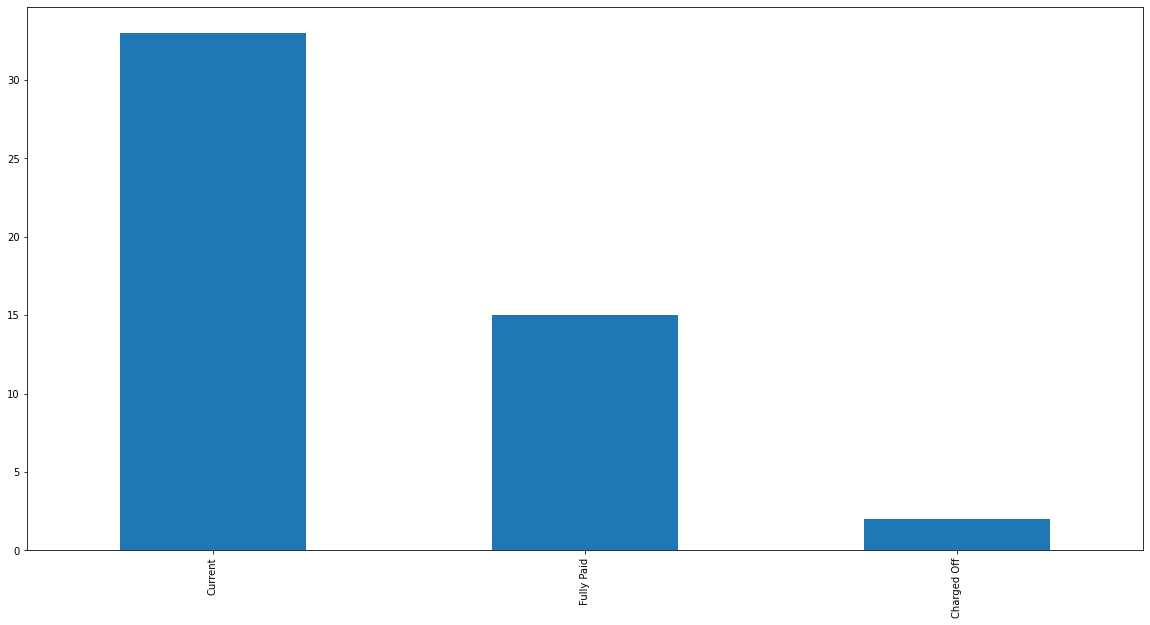

In [14]:
df_candidate['loan_status'].value_counts().plot(kind='bar', figsize=(20,10))

In [15]:
df_candidate['loan_status'].value_counts()

Current        33
Fully Paid     15
Charged Off     2
Name: loan_status, dtype: int64

Seems the group managed to pay back the money on time, only 2 person out of 50 are Charged Off.

#### 2. How about their Fico Score?

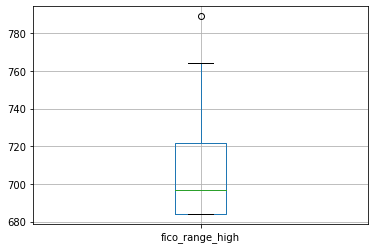

In [21]:
df_candidate.boxplot(column=['fico_range_high'])

The FICO Score for this group is quite okay even there is an outlier with score 789

#### 3. How about their Interest Rate?

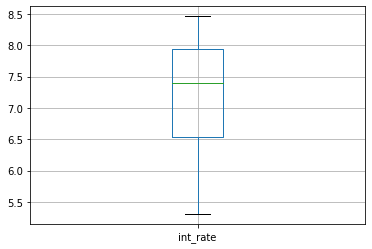

In [25]:
df_candidate.boxplot(column=['int_rate'])

This information would give the investor information needed on how much interest need to be charged to this applicant.

### Conclusion

By using Protodash, we may see that it is easier for Investor to identify their future investment opportunity by checking the performance of previous creditors.